# Evaluation of Extended A* Algorithm for Planar Robot Motion Planning
This notebook presents a comprehensive evaluation of the extended A* algorithm applied to planar robot motion planning across varying degrees of freedom (DoF). The analysis encompasses three robot configurations: 3-DoF, 6-DoF, and 9-DoF systems to assess algorithmic performance scalability with increasing configuration space dimensionality.

## Experimental Setup
The evaluation utilizes standardized test environments designed to maintain consistency across all DoF configurations. In the visualizations presented below, the green configuration represents the initial robot pose (start state), while the red configuration indicates the target pose (goal state).

To ensure fair comparison across different DoF systems, identical joint angle configurations are systematically applied to the corresponding joints of each robot variant. This approach isolates the impact of configuration space dimensionality on pathfinding performance while maintaining consistent spatial constraints and objectives across all test scenarios.

----- benchmark: simple -----


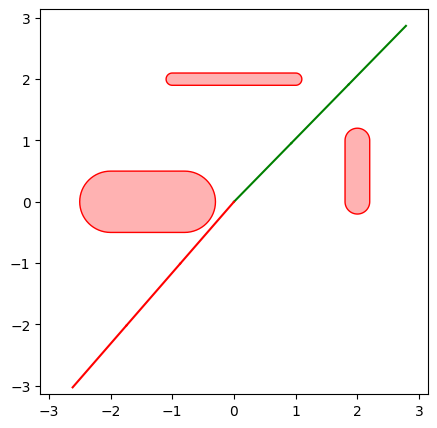

----- benchmark: medium -----


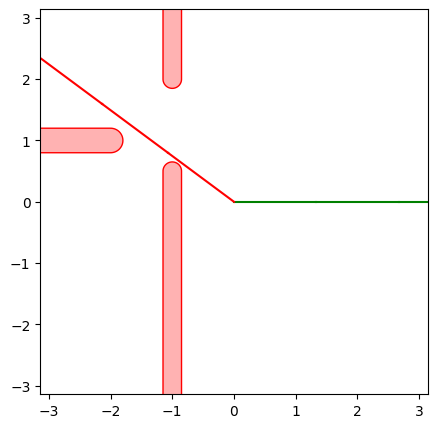

----- benchmark: complex -----


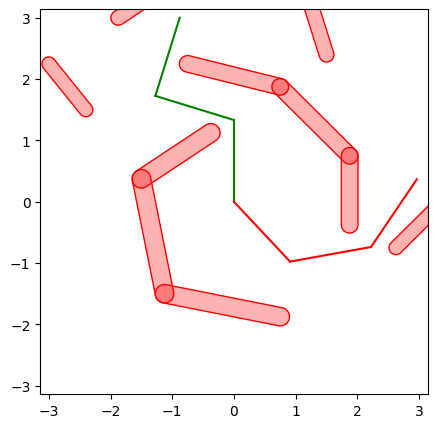

In [7]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'core'))
sys.path.append(os.path.join(os.getcwd(), 'evaluation/robotic_arm'))

import json
import copy
import numpy as np
import networkx as nx
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

from core.IPBenchmark import Benchmark
from core.IPAStarExtended import AStar
from core.IPLazyPRM import LazyPRM
from evaluation.robotic_arm.Benchmarking import get_config_dir_name, evaluate
import evaluation.robotic_arm.IPTestSuite_robotic_arm_3_DoF as ts3
import evaluation.robotic_arm.IPTestSuite_robotic_arm_6_DoF as ts6
import evaluation.robotic_arm.IPTestSuite_robotic_arm_9_DoF as ts9
from evaluation.robotic_arm.PlotEnvironments import visualizeBenchmark


for benchmark in ts3.benchList:
        benchmark: Benchmark
        print(f"----- benchmark: {benchmark.name} -----")
        fig, ax = visualizeBenchmark(benchmark)
        plt.show()

## Evaluation Code

This section presents the computational tools developed for the A* algorithm evaluation, loading and plotting the results, as well as animating the planar manipulator.

In [8]:
testSuits = {3: ts3, 6: ts6, 9: ts9}

def get_evaluation_results(configs: List[Dict], algorithm: str = "astar", dump: bool = True):
    results = []

    for i, config in enumerate(configs):
        print(f"----- config {i + 1} of {len(configs)} -----")

        config_results = {}

        ts = testSuits[config["dof"]]
        benchmarks = [ts.benchList[i] for i in config["benchmarks"]]
        for benchmark in benchmarks:
            print(f"----- benchmark: {benchmark.name} -----")
            benchmark_results = {}

            dir_name = get_config_dir_name(config=config, benchmark_name=benchmark.name, algorithm=algorithm)

            if os.path.exists(dir_name):  # load evaluation results if they exist.
                match algorithm:
                    case "astar":
                        solver = AStar(benchmark.collisionChecker)

                    case "prm":
                        solver = LazyPRM(benchmark.collisionChecker)
                
                solver.start = benchmark.startList[0]
                solver.goal = benchmark.goalList[0]
                with open(f'{dir_name}/graph.json') as f:
                    graph = nx.node_link_graph(json.load(f), edges="links")
                    solver.graph = graph
                with open(f'{dir_name}/stats.json') as f:
                    stats = json.load(f)
                with open(f'{dir_name}/solution.json') as f:
                    solution = json.load(f)

            else:  # do evaluation
                stats, solution, solver = evaluate(config=config, benchmark=benchmark, algorithm=algorithm, dump=dump)

            benchmark_results["stats"] = stats
            benchmark_results["solution"] = solution
            benchmark_results["solver"] = solver
            config_results[benchmark.name] = benchmark_results

        results.append((config, config_results))
    return results

In [9]:
def plot_results_line(results: List, x_axis_values: List, x_axis_title: str):
    # plot execution time
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            plot_lines[bench_name].append(benchmark_results["stats"]["execution_time"])

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Execution Time")
    plt.xlabel(x_axis_title)
    plt.ylabel("Execution Time [s]")
    plt.show()

    # plot roadmap size
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            plot_lines[bench_name].append(benchmark_results["stats"]["road_map_size"])

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Roadmap Size")
    plt.xlabel(x_axis_title)
    plt.ylabel("Roadmap Size")
    plt.show()

    # plot nume nodes in solution path
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            if (benchmark_results["stats"]["num_nodes_solution_path"] >= 0):
                plot_lines[bench_name].append(benchmark_results["stats"]["num_nodes_solution_path"])
            else:
                plot_lines[bench_name].append(np.nan)

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)

    plt.legend()
    plt.title("Number of Nodes in Solution Path")
    plt.xlabel(x_axis_title)
    plt.ylabel("Number of Nodes in Solution Path")
    plt.show()

    # plot solution path length
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            if (benchmark_results["stats"]["solution_path_length"] >= 0):
                plot_lines[bench_name].append(benchmark_results["stats"]["solution_path_length"])
            else:
                plot_lines[bench_name].append(np.nan)

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)

    plt.legend()
    plt.title("Solution Path Length")
    plt.xlabel(x_axis_title)
    plt.ylabel("Solution Path Length")
    plt.show()

In [10]:
def plot_results_bar(results: List, x_axis_values: List, x_axis_title: str):
    # Get benchmark names
    bench_names = list(results[0][1].keys())
    n_benchmarks = len(bench_names)
    n_configs = len(x_axis_values)
    
    # Set up bar positioning
    bar_width = 0.8 / n_configs  # Total width of 0.8, divided by number of configs
    x_positions = np.arange(n_benchmarks)
    
    # Plot execution time
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        execution_times = []
        for bench_name in bench_names:
            _, config_results = results[i]
            execution_times.append(config_results[bench_name]["stats"]["execution_time"])
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, execution_times, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Execution Time [s]')
    plt.title('Execution Time by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot roadmap size
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        roadmap_sizes = []
        for bench_name in bench_names:
            _, config_results = results[i]
            roadmap_sizes.append(config_results[bench_name]["stats"]["road_map_size"])
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, roadmap_sizes, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Roadmap Size')
    plt.title('Roadmap Size by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot number of nodes in solution path
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        num_nodes = []
        for bench_name in bench_names:
            _, config_results = results[i]
            val = config_results[bench_name]["stats"]["num_nodes_solution_path"]
            num_nodes.append(val if val >= 0 else np.nan)
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, num_nodes, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Number of Nodes in Solution Path')
    plt.title('Number of Nodes in Solution Path by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot solution path length
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        path_lengths = []
        for bench_name in bench_names:
            _, config_results = results[i]
            val = config_results[bench_name]["stats"]["solution_path_length"]
            path_lengths.append(val if val >= 0 else np.nan)
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, path_lengths, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Solution Path Length')
    plt.title('Solution Path Length by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
def interpolate_line(startPos, endPos, step_l):
    steps = []
    line = np.array(endPos) - np.array(startPos)
    line_l = np.linalg.norm(line)
    step = line / line_l * step_l
    n_steps = np.floor(line_l / step_l).astype(np.int32)
    c_step = np.array(startPos)
    for i in range(n_steps):
        steps.append(copy.deepcopy(c_step))
        c_step += step
    if not (c_step == np.array(endPos)).all():
        steps.append(np.array(endPos))
    return steps

matplotlib.rcParams['animation.embed_limit'] = 64
def animateSolution(planner, environment, solution, dof):
    _planner = planner
    _environment = environment
    _solution = solution
    
    fig_local = plt.figure(figsize=(7, 7))
    ax = fig_local.add_subplot(1, 1, 1)
    ## get positions for solution
    solution_pos = [_planner.graph.nodes[node]['pos'] for node in _solution]
    ## interpolate to obtain a smoother movement
    i_solution_pos = [solution_pos[0]]
    for i in range(1, len(solution_pos)):
        segment_s = solution_pos[i-1]
        segment_e = solution_pos[i]
        i_solution_pos = i_solution_pos + interpolate_line(segment_s, segment_e, 0.1)[1:]

    ## animate
    frames = len(i_solution_pos)
    
    def animate(t):
        ## clear task space figure
        ax.cla()
        ## fix figure size
        ax.set_xlim([-3,3])
        ax.set_ylim([-3,3])
        ## draw obstacles
        _environment.drawObstacles(ax, inWorkspace = True)
        ## update robot position
        pos = i_solution_pos[t]
        _environment.kin_chain.move(pos)
        planarRobotVisualize(_environment.kin_chain, ax)

    ani = matplotlib.animation.FuncAnimation(fig_local, animate, frames=frames)
    html = HTML(ani.to_jshtml())
    display(html)
    plt.close()

def planarRobotVisualize(kin_chain, ax):
    joint_positions = kin_chain.get_transforms()
    for i in range(1, len(joint_positions)):
        xs = [joint_positions[i-1][0], joint_positions[i][0]]
        ys = [joint_positions[i-1][1], joint_positions[i][1]]
        ax.plot(xs, ys, color='g')

## Evaluation: Discretization

This section analyzes the impact of discretization resolution on A* algorithm performance. The discretization parameter directly influences the granularity of the configuration space representation, affecting both solution quality and computational complexity.

Due to the exponential growth of the search space with increasing degrees of freedom, we had to use coarser discretization levels for higher-DoF systems. The 6-DoF and 9-DoF evaluations are therefore conducted with reduced discretization steps to maintain feasible computation times, while the 3-DoF system permits evaluation across a broader range of discretization parameters.

### 3DoF

----- config 1 of 5 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 2 of 5 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 3 of 5 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 4 of 5 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 5 of 5 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----


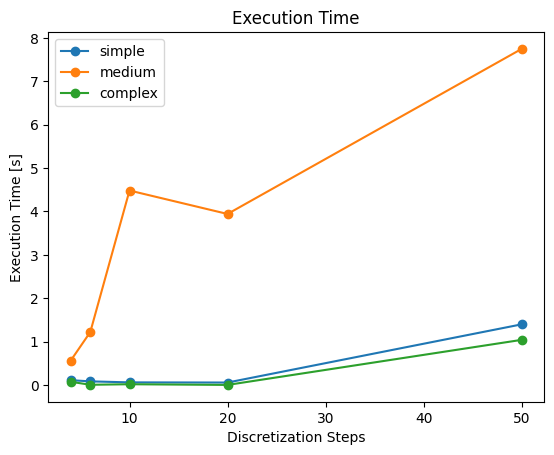

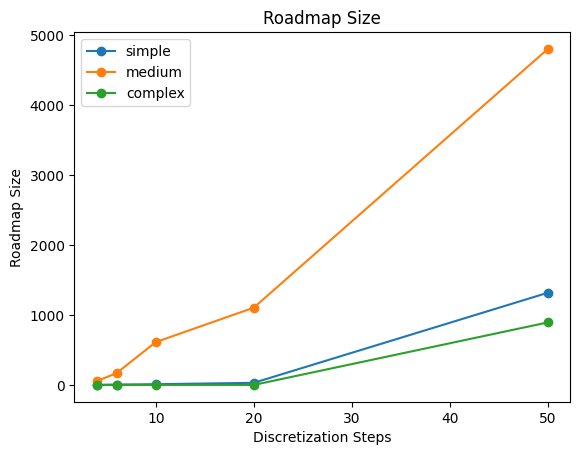

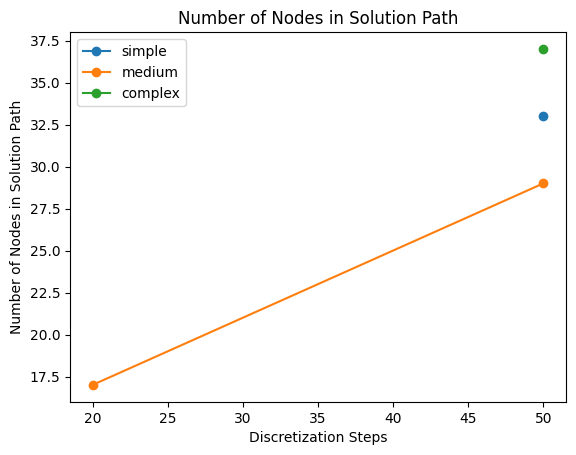

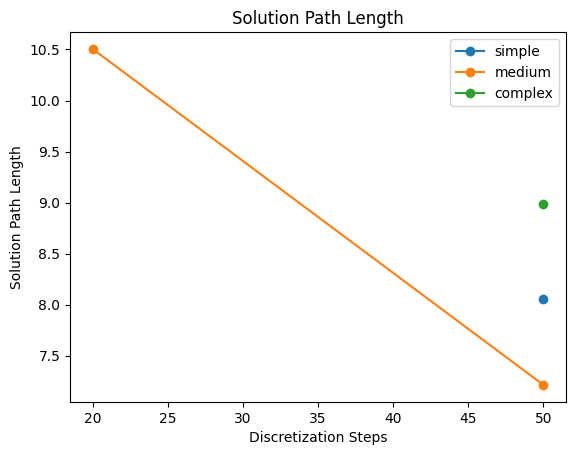

In [12]:
disc_values = [4, 6, 10, 20, 50]

configs = []
for disc in disc_values:
    disc_config = dict()
    disc_config["dof"] = 3
    disc_config["lowLimits"] = [-2 *np.pi for _ in range(disc_config["dof"])]
    disc_config["highLimits"] = [2 *np.pi for _ in range(disc_config["dof"])]
    disc_config["discretization"] = [disc for _ in range(disc_config["dof"])]
    disc_config["w"] = .5
    disc_config["heuristic"]  = "euclidean"
    disc_config["reopen"] = True
    disc_config["check_connection"] = True
    disc_config["lazy_check_connection"] = True
    disc_config["benchmarks"] = [0, 1, 2]

    configs.append(disc_config)

results = get_evaluation_results(configs=configs)

plot_results_line(results=results, x_axis_values=disc_values, x_axis_title="Discretization Steps")

### 6DoF

----- config 1 of 4 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 2 of 4 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 3 of 4 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 4 of 4 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----


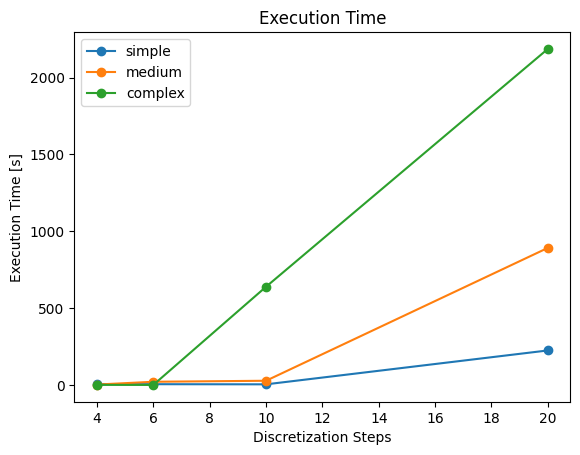

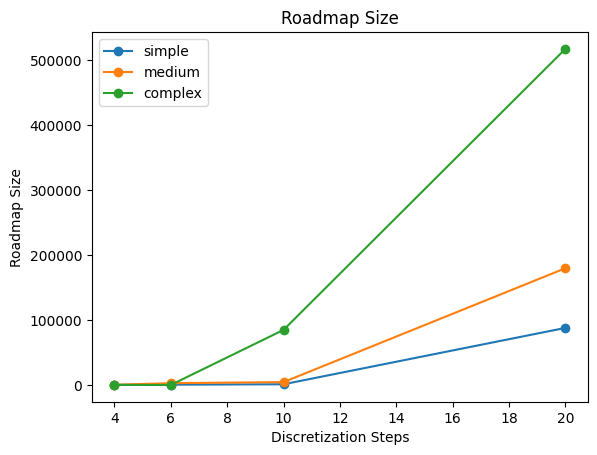

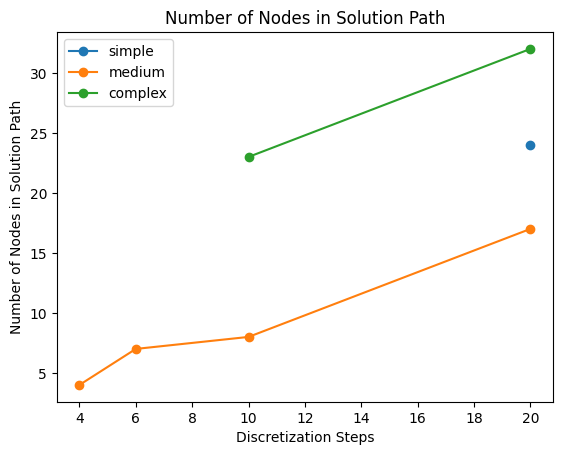

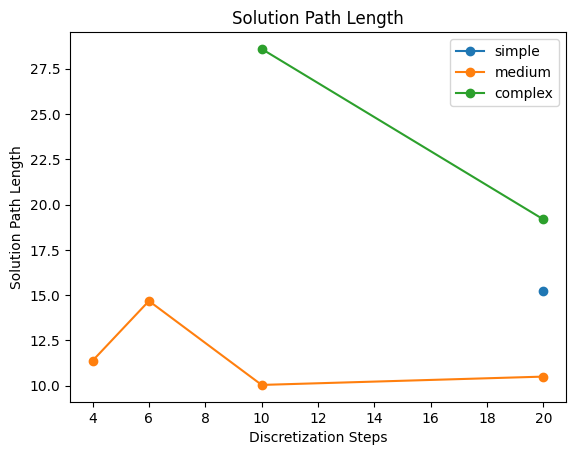

In [13]:
disc_values = [4, 6, 10, 20]

configs = []
for disc in disc_values:
    disc_config = dict()
    disc_config["dof"] = 6
    disc_config["lowLimits"] = [-2 *np.pi for _ in range(disc_config["dof"])]
    disc_config["highLimits"] = [2 *np.pi for _ in range(disc_config["dof"])]
    disc_config["discretization"] = [disc for _ in range(disc_config["dof"])]
    disc_config["w"] = .5
    disc_config["heuristic"]  = "euclidean"
    disc_config["reopen"] = True
    disc_config["check_connection"] = True
    disc_config["lazy_check_connection"] = True
    disc_config["benchmarks"] = [0, 1, 2]

    configs.append(disc_config)

results = get_evaluation_results(configs=configs)

plot_results_line(results=results, x_axis_values=disc_values, x_axis_title="Discretization Steps")

### 9DoF

----- config 1 of 2 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 2 of 2 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----


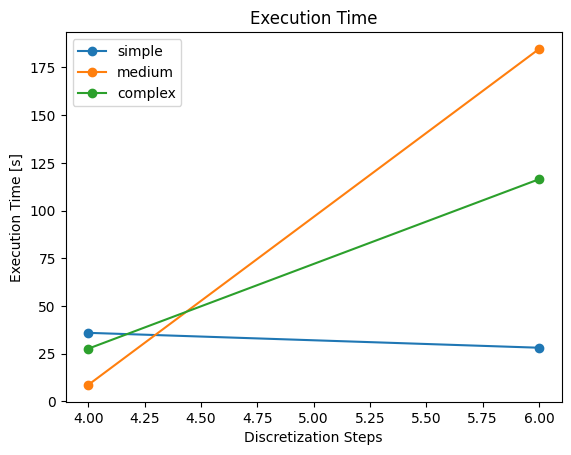

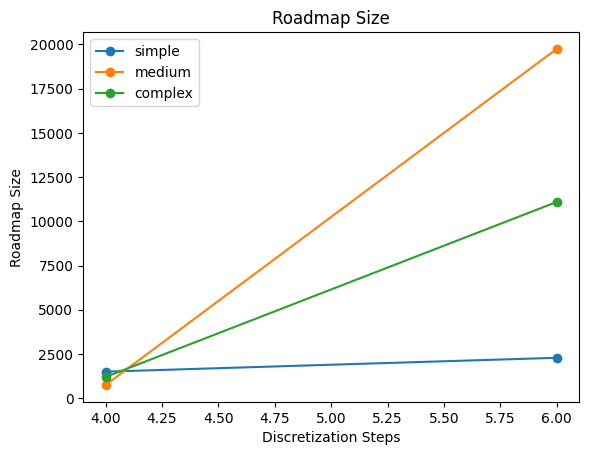

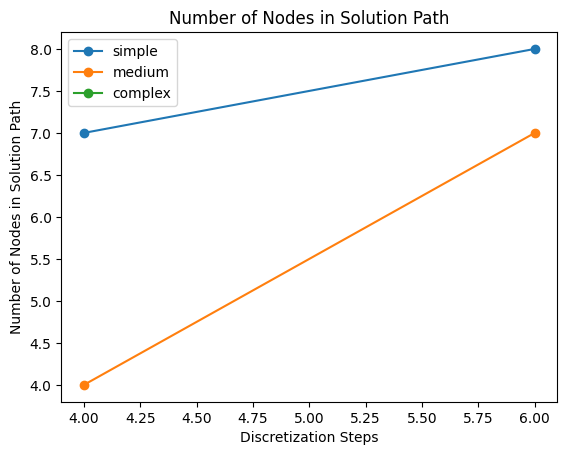

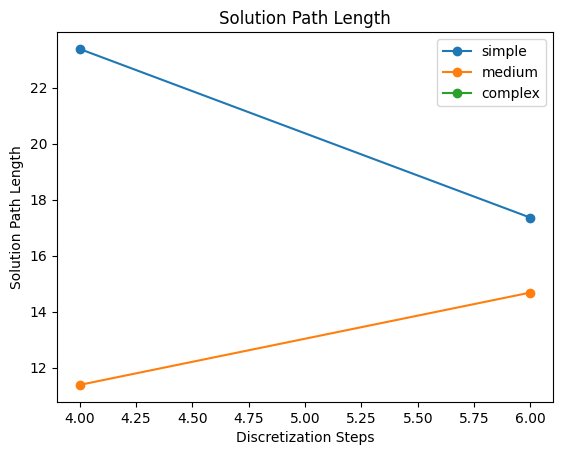

In [14]:
disc_values = [4, 6]

configs = []
for disc in disc_values:
    disc_config = dict()
    disc_config["dof"] = 9
    disc_config["lowLimits"] = [-2 *np.pi for _ in range(disc_config["dof"])]
    disc_config["highLimits"] = [2 *np.pi for _ in range(disc_config["dof"])]
    disc_config["discretization"] = [disc for _ in range(disc_config["dof"])]
    disc_config["w"] = .5
    disc_config["heuristic"]  = "euclidean"
    disc_config["reopen"] = True
    disc_config["check_connection"] = True
    disc_config["lazy_check_connection"] = True
    disc_config["benchmarks"] = [0, 1, 2]

    configs.append(disc_config)

results = get_evaluation_results(configs=configs)

plot_results_line(results=results, x_axis_values=disc_values, x_axis_title="Discretization Steps")

### Evaluation Results

**Computational Performance**
The execution time generally increases with the number of discretization steps. For higher numbers of DoF, this increase is so rapid that we had to choose different maximum numbers of discretization steps for each robot arm. This is expected because the upper bound for the roadmap size grows exponentially with the DoF. For example, for 6 DoF and 20 discretization steps, the explored roadmap already consists of over 500,000 nodes.

**Path Length**
Other than in the 2-DoF case, there is no clear trend in the path length. Theoretically, increasing discretization resolution should asymptotically converge toward optimal path lengths for each DoF-environment combination, as finer granularity provides a better approximation of continuous optimal trajectories. However, our computational resources do not allow us to show this experimentally.

## Evaluation: Weight w

This section examines the impact of the heuristic weight parameter w on A* algorithm performance characteristics. The weight w modulates the influence of the heuristic in the A* search process, balancing exploration and exploitation. A higher w value increases the heuristic's influence, potentially leading to faster convergence at the cost of solution optimality.
For this experiment, we use 3 DoF and 50 discretization steps.

----- config 1 of 3 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 2 of 3 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 3 of 3 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----


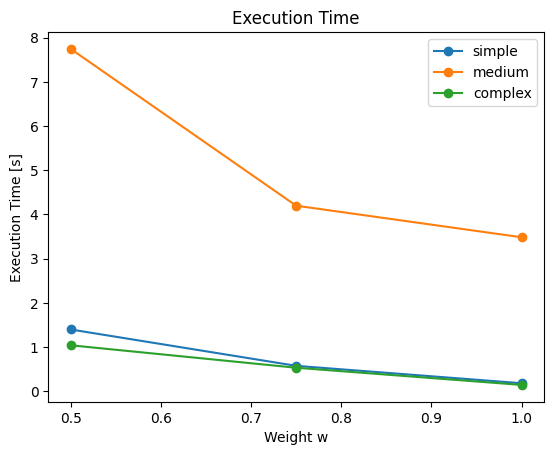

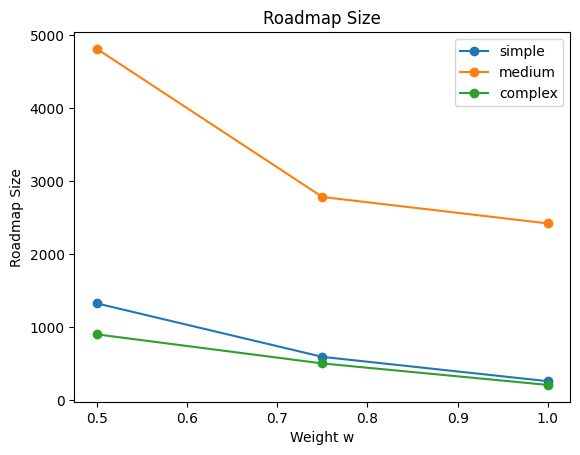

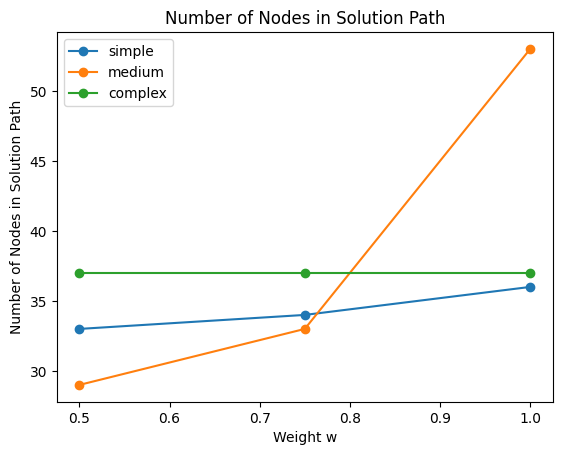

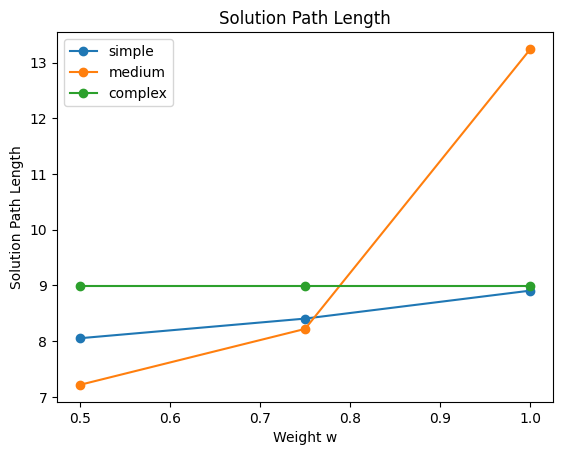

In [15]:
w_values = [0.5, 0.75, 1]

configs = []
for w in w_values:
        w_config  = dict()
        w_config["dof"] = 3
        w_config["lowLimits"] = [-2 *np.pi for _ in range(w_config["dof"])]
        w_config["highLimits"] = [2 *np.pi for _ in range(w_config["dof"])]
        w_config["discretization"] = [50 for _ in range(w_config["dof"])]
        w_config["w"] = w
        w_config["heuristic"]  = "euclidean"
        w_config["reopen"] = True
        w_config["check_connection"] = True
        w_config["lazy_check_connection"] = True
        w_config["benchmarks"] = [0, 1, 2]

        configs.append(w_config)

results = get_evaluation_results(configs=configs)

plot_results_line(results=results, x_axis_values=w_values, x_axis_title="Weight w")

### Evaluation Results
**Computational Performance**
Increasing the w value leads to significant improvements in the execution time in this experiment, leading to twice as fast path planning in all test cases. This is the case because w increases the influence of the heuristic, which is driving the exploration towards the goal.

**Path Length**
Of course, a w value that is higher than 0.5 also means that the solution is not necessarily optimal anymore, which manifests in an increase of the path length. Notice that for the medium test case, the path for `w = 1.0` is twice as long as for `w = 0.5`. This change is not visible in the other two test cases, indicating that the path length changes seem to be highly dependent on the environment. A value of `w = 0.75` seems to be a good compromise between execution time and path length, as it leads to a reasonably short path in all test cases, while still being significantly faster than `w = 0.5`.

## Evaluation: Comparison to LazyPRM

This section presents a comparative evaluation between the extended A* algorithm and LazyPRM.
For Lazy PRM, we use the following parameter values:

initialRoadmapSize = 500     
updateRoadmapSize  = 50    
kNearest = 20       
maxIterations = 100     

### 3DoF

In this experiment, we use 50 discretization steps for A*.

----- config 1 of 1 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 1 of 1 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----


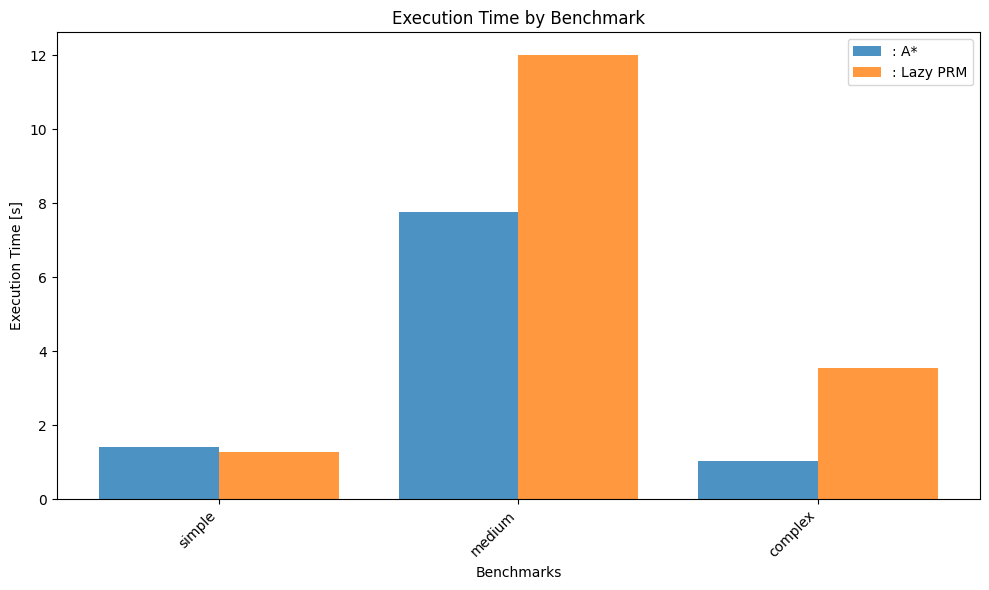

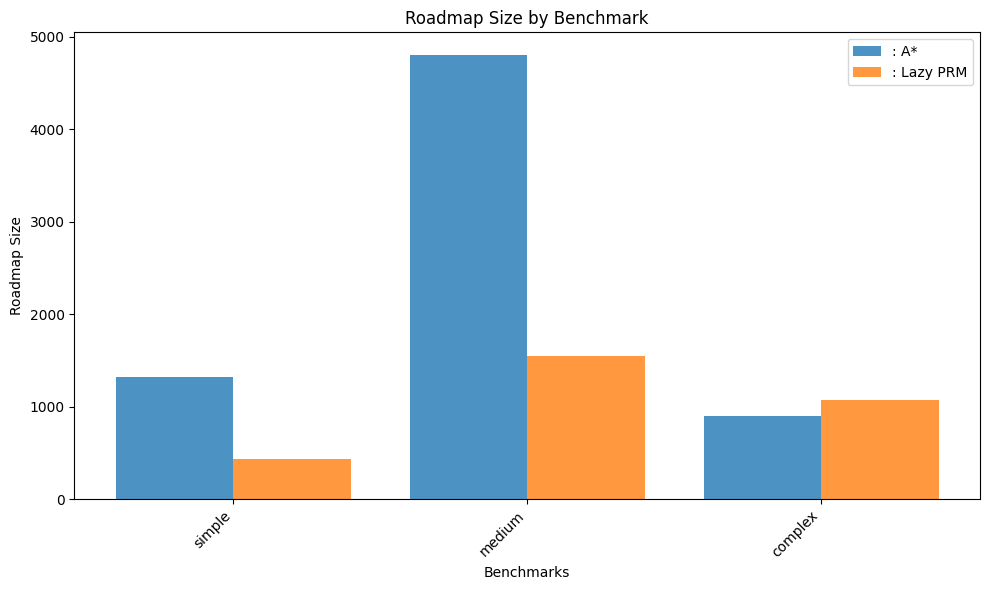

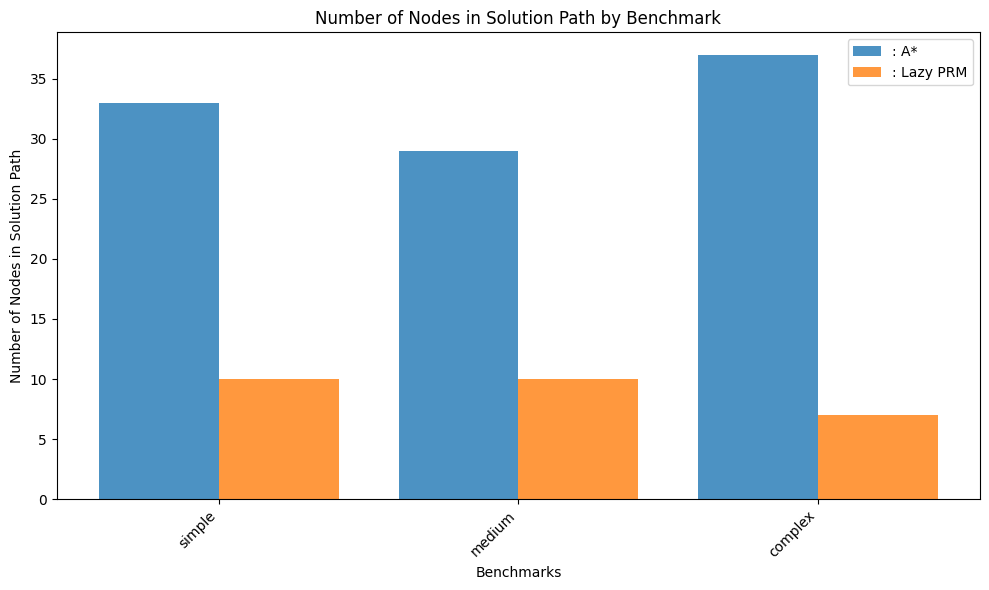

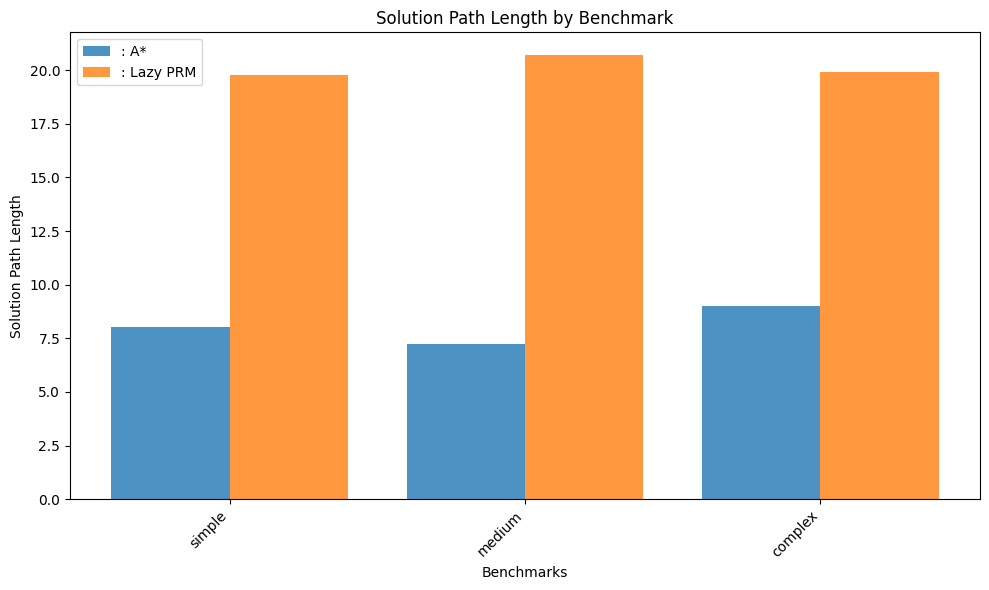

In [16]:
algorithms = ["A*", "Lazy PRM"]

configs = []

astar_config  = dict()
astar_config["dof"] = 3
astar_config["lowLimits"] = [-2 *np.pi for _ in range(astar_config["dof"])]
astar_config["highLimits"] = [2 *np.pi for _ in range(astar_config["dof"])]
astar_config["discretization"] = [50 for _ in range(astar_config["dof"])]
astar_config["w"] = 0.5
astar_config["heuristic"]  = "euclidean"
astar_config["reopen"] = True
astar_config["check_connection"] = True
astar_config["lazy_check_connection"] = True
astar_config["benchmarks"] = [0, 1, 2]

configs.append(astar_config)

results_3DoF = get_evaluation_results(configs=configs, algorithm="astar")
results_3DoF.extend(get_evaluation_results(configs=configs, algorithm="prm"))

plot_results_bar(results=results_3DoF, x_axis_values=algorithms, x_axis_title="")

### 6DoF

In this experiment, we use 20 discretization steps for A*.

----- config 1 of 1 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 1 of 1 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----


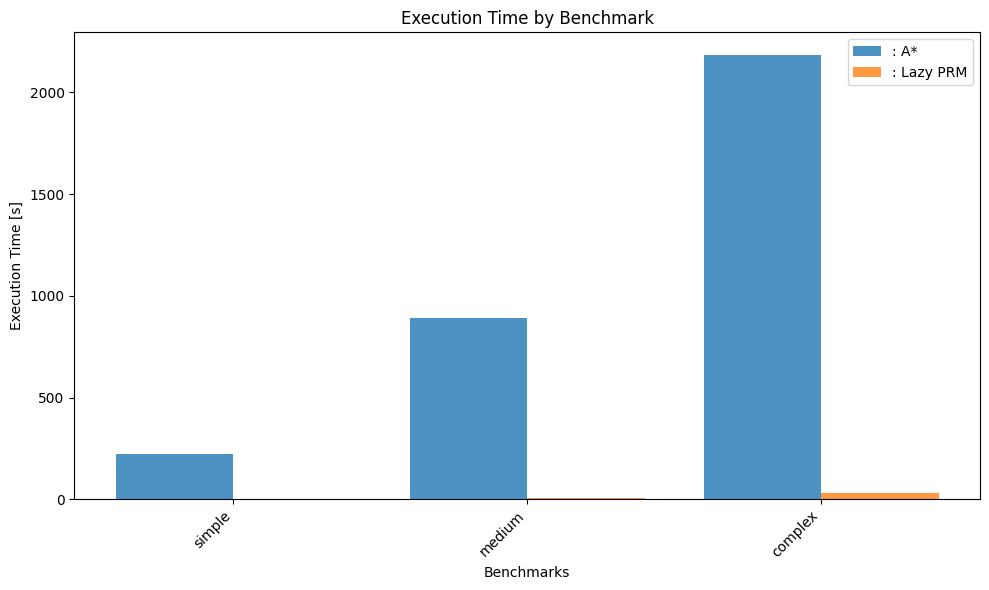

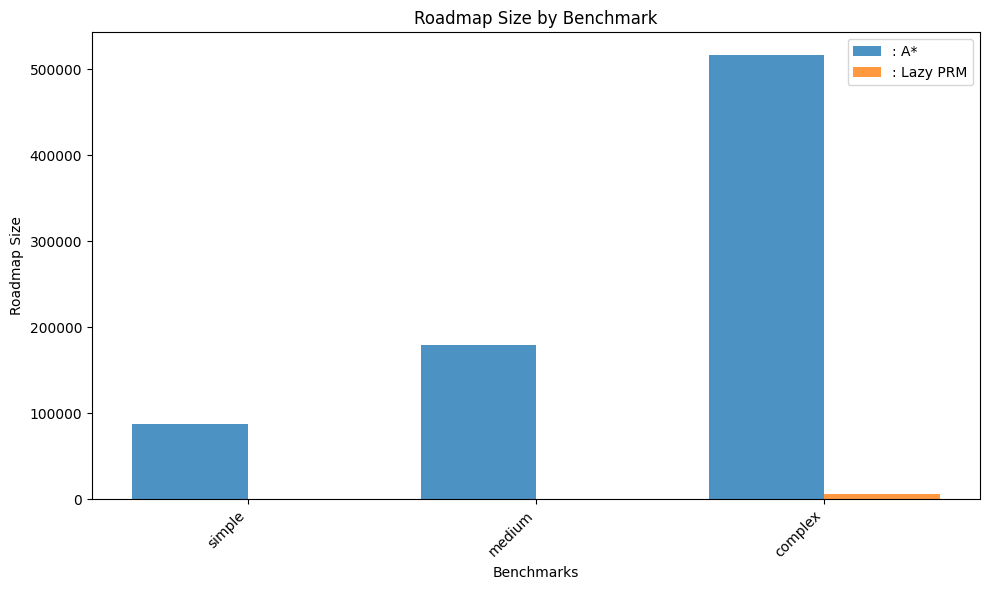

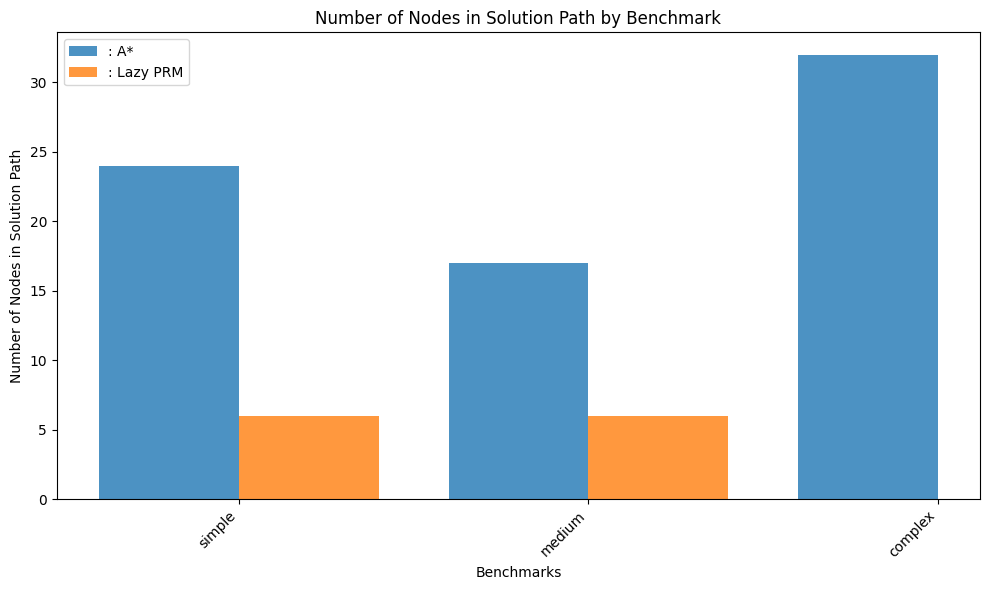

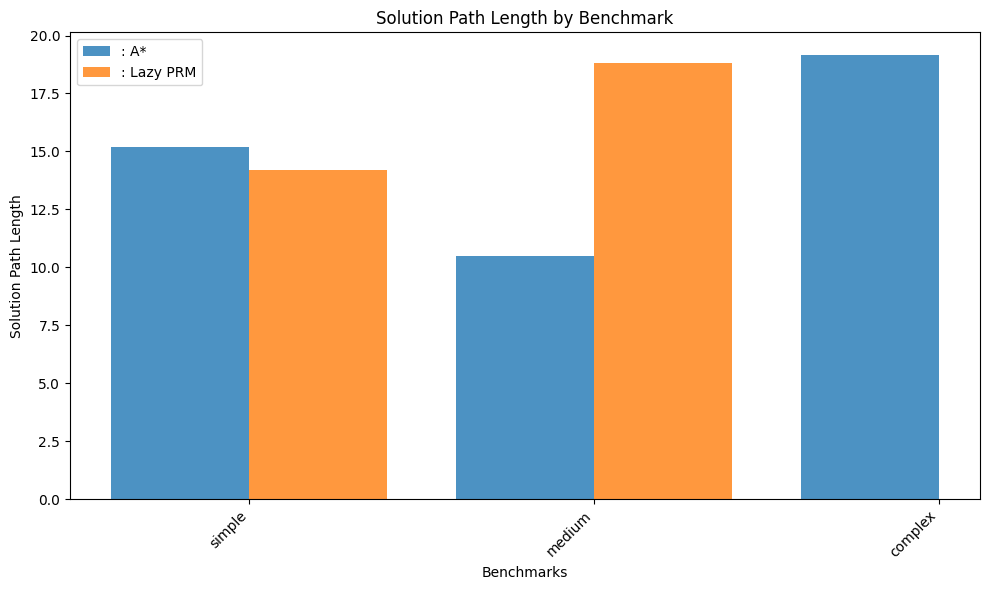

In [17]:
algorithms = ["A*", "Lazy PRM"]

configs = []

astar_config  = dict()
astar_config["dof"] = 6
astar_config["lowLimits"] = [-2 *np.pi for _ in range(astar_config["dof"])]
astar_config["highLimits"] = [2 *np.pi for _ in range(astar_config["dof"])]
astar_config["discretization"] = [20 for _ in range(astar_config["dof"])]
astar_config["w"] = 0.5
astar_config["heuristic"]  = "euclidean"
astar_config["reopen"] = True
astar_config["check_connection"] = True
astar_config["lazy_check_connection"] = True
astar_config["benchmarks"] = [0, 1, 2]

configs.append(astar_config)

results_6DoF = get_evaluation_results(configs=configs, algorithm="astar")
results_6DoF.extend(get_evaluation_results(configs=configs, algorithm="prm"))

plot_results_bar(results=results_6DoF, x_axis_values=algorithms, x_axis_title="")

### 9DoF

In this experiment, we use 6 discretization steps for A*.

----- config 1 of 1 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----
----- config 1 of 1 -----
----- benchmark: simple -----
----- benchmark: medium -----
----- benchmark: complex -----


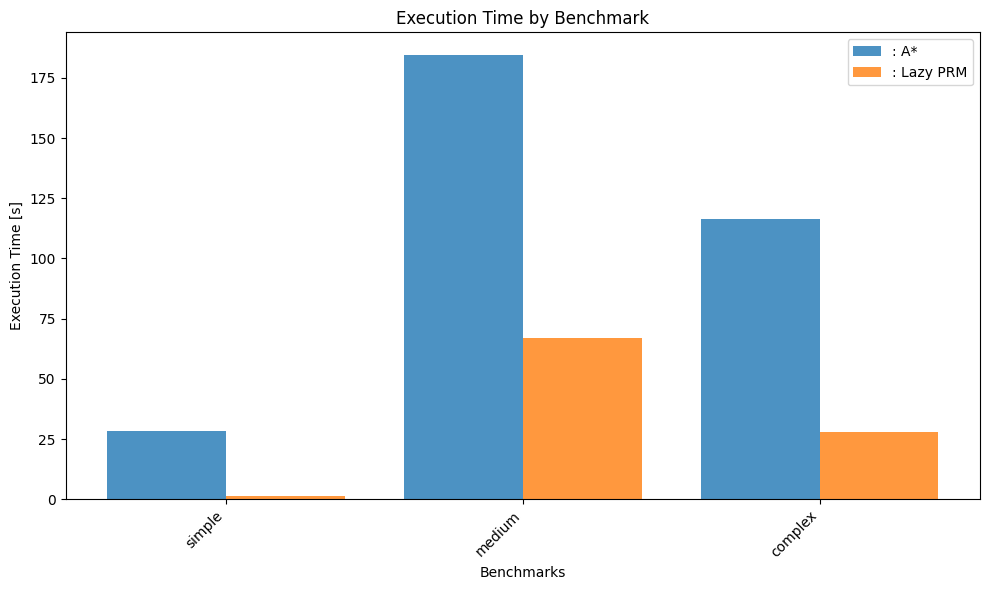

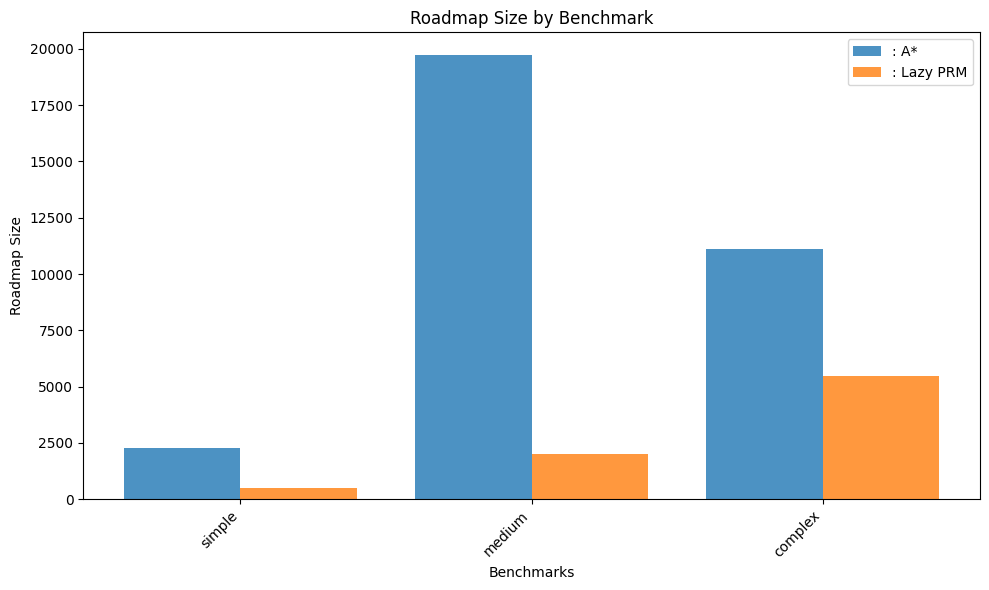

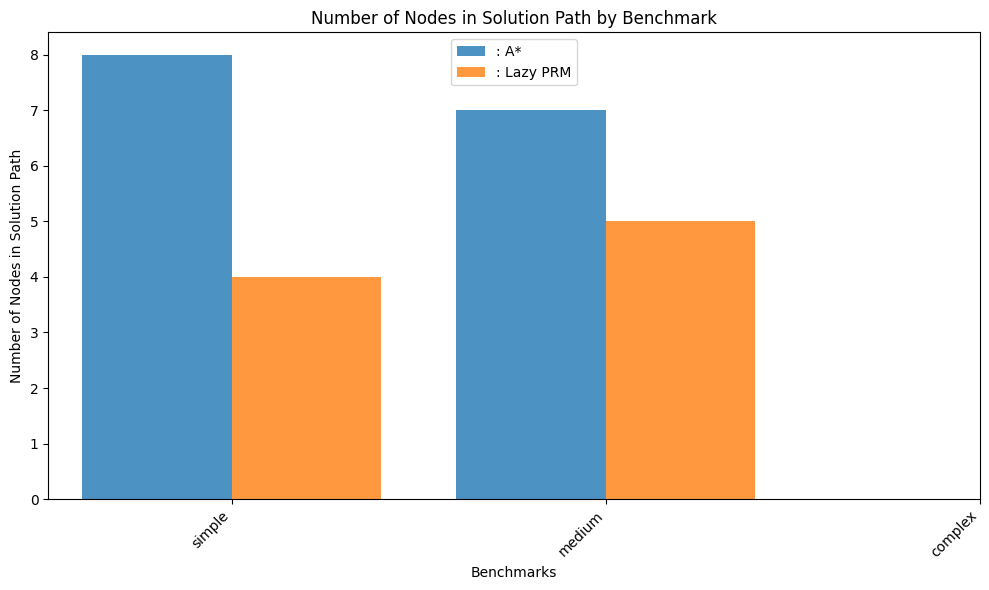

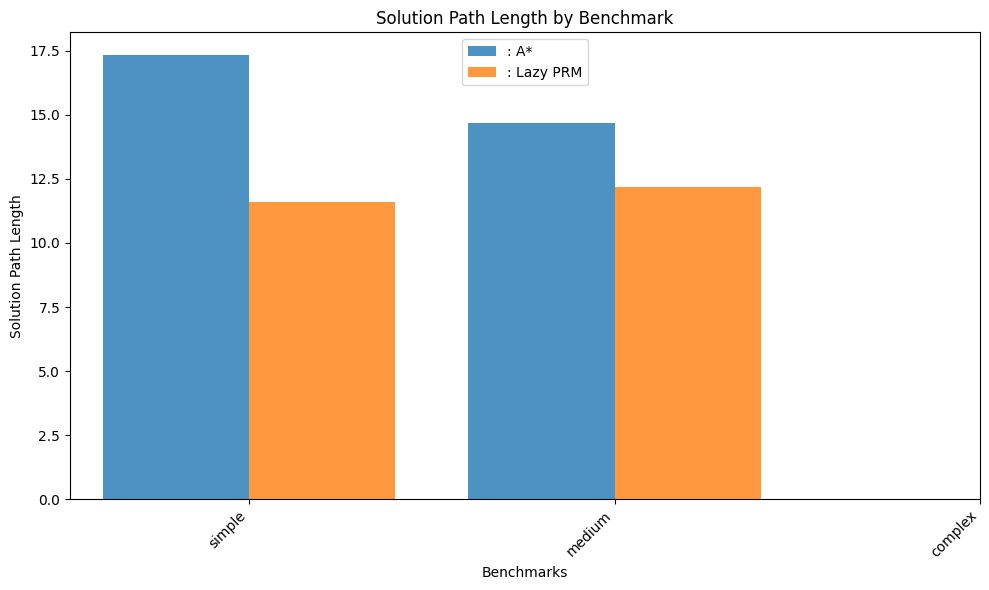

In [18]:
algorithms = ["A*", "Lazy PRM"]

configs = []

astar_config  = dict()
astar_config["dof"] = 9
astar_config["lowLimits"] = [-2 *np.pi for _ in range(astar_config["dof"])]
astar_config["highLimits"] = [2 *np.pi for _ in range(astar_config["dof"])]
astar_config["discretization"] = [6 for _ in range(astar_config["dof"])]
astar_config["w"] = 0.5
astar_config["heuristic"]  = "euclidean"
astar_config["reopen"] = True
astar_config["check_connection"] = True
astar_config["lazy_check_connection"] = True
astar_config["benchmarks"] = [0, 1, 2]

configs.append(astar_config)

results_9DoF = get_evaluation_results(configs=configs, algorithm="astar")
results_9DoF.extend(get_evaluation_results(configs=configs, algorithm="prm"))

plot_results_bar(results=results_9DoF, x_axis_values=algorithms, x_axis_title="")

### Evaluation Results
Most of the time, LazyPRM is significantly faster than A*. This is the case because A* explores the configuration space systematically in fixed grid steps, while LazyPRM samples configurations leading to  a much smaller roadmap. We also always perform collision checking for the connections in A*, which is very expensive.

However, while A* will always find the optimal solution for the given discretization, LazyPRM often fails to find a solution for high DoF and complex, narrow environments. This encourages usage of A* for narrow, limited environments, as a path will always be found, while LazyPRM might fail to find a path at all.

The length of the paths found by LazyPRM is mostly significantly longer than the paths found by A*. This is to be expected, because A* finds optimal paths, while LazyPRM just searches for any path. The few cases where the path found by Lazy PRM is shorter than the path found by A* can be attributed to the fact that A* only changes one joint angle per step in this implementation, while LazyPRM can change multiple DoF simultaneously. For A*, this is only possible if we allow diagonal movements, which we do not do in this implementation.

#### Example Result A*:

In [19]:
result = results_3DoF[0][1]["complex"]
solver = result["solver"]
environment = solver._collisionChecker
solution = result["solution"]
animateSolution(planner=solver, environment=environment, solution=solution, dof=3)

####  Example Result PRM:

In [20]:
result = results_3DoF[1][1]["complex"]
solver = result["solver"]
environment = solver._collisionChecker
solution = result["solution"]
print(solution)
animateSolution(planner=solver, environment=environment, solution=solution, dof=3)

['start', 1378, 1009, 511, 510, 693, 'goal']


LazyPRM results in smoother motions than A*, because more than one joint can be moved simultaneously. However, the solution path found by A* is shorter in most cases. You can see that the arm in the A* only narrowly avoids the obstacles. This is a symptom of A* only changing the configuration as much as necessary.